In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import sqlite3
import matplotlib.pyplot as plt


2025-01-07 20:39:24.635512: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20


/opt/anaconda3/envs/dev/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - loss: 0.0169 - val_loss: 0.0019
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0012 - val_loss: 0.0031
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0012 - val_loss: 0.0045
Epoch 9/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 10/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0011 - val_loss: 0.0022
Epoch 11/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 12/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0010 - val_l

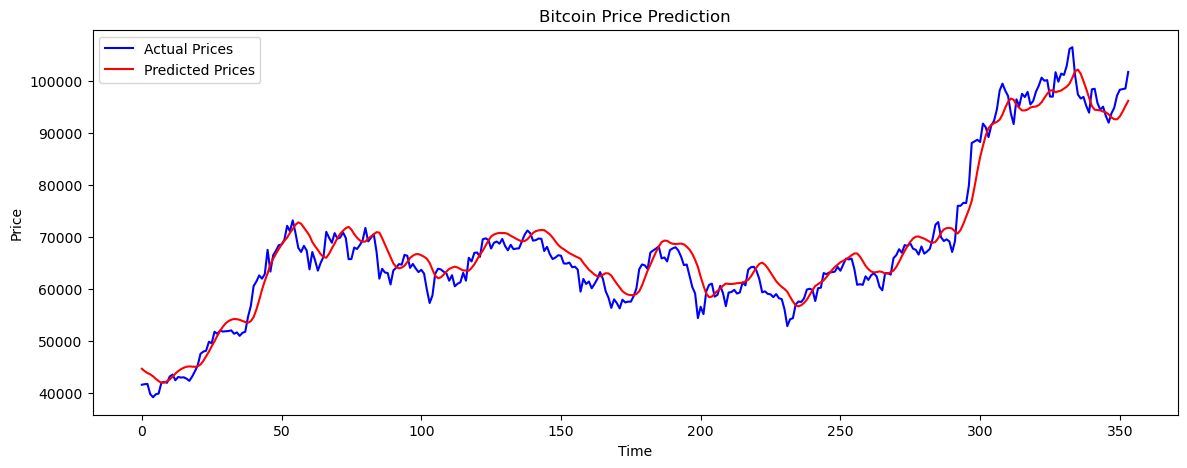

In [2]:

# Load data into an SQLite database
conn = sqlite3.connect('crypto_data.db')

# Load CSV files into the database
crypto_files = {
    "Bitcoin": "Bitcoin_data.csv",
    "Dogecoin": "Dogecoin_data.csv",
    "Ethereum": "Ethereum_data.csv",
    "Litecoin": "Litecoin_data.csv",
    "SPY": "SPY_data.csv",
    "XRP": "XRP_data.csv"
}

for name, file in crypto_files.items():
    df = pd.read_csv(file)
    df.to_sql(name, conn, if_exists='replace', index=False)

# Query the data for Bitcoin
query = """
SELECT Date, PX_HIGH, PX_LOW, PX_LAST 
FROM Bitcoin
WHERE PX_HIGH IS NOT NULL AND PX_LOW IS NOT NULL AND PX_LAST IS NOT NULL;
"""
data = pd.read_sql(query, conn)

# Close the connection
conn.close()

# Sort data by most recent dates
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values(by='Date', ascending=True)

# Data Cleaning and Normalization
data = data[['Date', 'PX_LAST']].dropna()
data.set_index('Date', inplace=True)
scaler = MinMaxScaler(feature_range=(0, 1))
data['PX_LAST'] = scaler.fit_transform(data[['PX_LAST']])

# Prepare data for LSTM
look_back = 60
def create_dataset(dataset):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

values = data['PX_LAST'].values.reshape(-1, 1)
X, Y = create_dataset(values)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split into training and testing
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

# Build LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, Y_train, epochs=20, batch_size=32, validation_data=(X_test, Y_test), verbose=1)

# Evaluate the model
predicted = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted)
actual_prices = scaler.inverse_transform(Y_test.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
r2 = r2_score(actual_prices, predicted_prices)

# Save optimization data
optimization_data = pd.DataFrame({
    'Epoch': range(1, len(history.history['loss']) + 1),
    'Training Loss': history.history['loss'],
    'Validation Loss': history.history['val_loss']
})
optimization_data.to_csv('optimization_log.csv', index=False)

# Display results
print(f"RMSE: {rmse}")
print(f"R^2 Score: {r2}")

# Visualization
plt.figure(figsize=(14, 5))
plt.plot(actual_prices, color='blue', label='Actual Prices')
plt.plot(predicted_prices, color='red', label='Predicted Prices')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()